<div style="text-align: right"> Arnau Garriga Riba </div>

# Graph representations of flags similarity

### Table of contents:
* [Introduction](#Introduction)
* [Data preparation](#Data-preparation)
* [Auxiliar functions](#Auxiliar-functions)
* [Model Preparation](#Model-preparation)
* [TOP10 Similarity](#TOP10-Similarity)
* [GRAPHS](#GRAPHS)
 * [First graph: Directed and weighted graph with all the edges](#First-graph:-Directed-and-weighted-graph-with-all-the-edges)
 * [Second graph: Austria graph](#Second-graph:-Austria-graph)
 * [Third graph: Undirected shorter graph with the best edges](#Third-graph:-Undirected-shorter-graph-with-the-best-edges)
 * [Fourth graph: Path graph](#Fourth-graph:-Path-graph)
 * [Fifth graph: European graph](#Fifth-graph:-European-graph)
 * [Sixth graph: TOP population graph](#Sixth-graph:-TOP-population-graph)

## Introduction

In this notebook we have a group of graphs that show the similarity between the flags of the 214 countries and territories.<br>

The dataset used has information of some of the characteristics of the country (landmass, zone, area, population, language & religion) and also information about the flag (bars, n_stripes, n_circles...). It has been obtained from the web: https://archive.ics.uci.edu/ml/datasets/Flags<br>

The dataset was made in 1986, so it's very outdated. Knowing that, I've modified the dataset by:
- Adding some countries that didn't exist by the time (Russia, Serbia, Lithuania...).
- Updating the flags that have been changed recently (Mauritania, Venezuela, Malawi...).
- Updating the info that I will need for some graphs (landmass and population).
- Also, I've changed the criterion of the 23th variable (sunstars). Instead of counting the number of sun/stars, the columns value is:<br>
    0 -> If no sun/stars<br>
    1 -> If it has one sun/star<br>
    2 -> If it has multiple sun/stars

## Data preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import networkx as nx
import matplotlib.pyplot as plt
import json
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

In [2]:
# Loading the csv

df = pd.read_csv('flag_data.csv')
df = df.rename(columns={'name':'country'})
df.head()

,country,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5.0,1.0,648.0,16.0,10.0,2.0,3,0,4,...,0,0,0,0,0,1,0,1,black,green
1,Albania,3.0,1.0,29.0,3.0,6.0,6.0,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4.0,1.0,2388.0,20.0,8.0,2.0,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6.0,3.0,0.0,0.0,1.0,1.0,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3.0,1.0,0.0,0.0,6.0,0.0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


In [3]:
# We encode the categorical columns (mainhue, topleft & botright)

from sklearn.preprocessing import LabelEncoder

categ = ['mainhue','topleft','botright']

lists = []
for i in categ:
    lists.append(list(df[i]))

flat_list = [item for sublist in lists for item in sublist]

le = LabelEncoder()
transformed = le.fit_transform(flat_list)

for i in range(3):
    j = i+1
    df[categ[i]] = transformed[i*214:j*214]

df.head()

,country,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5.0,1.0,648.0,16.0,10.0,2.0,3,0,4,...,0,0,0,0,0,1,0,1,0,4
1,Albania,3.0,1.0,29.0,3.0,6.0,6.0,0,0,3,...,0,0,1,0,0,0,1,0,6,6
2,Algeria,4.0,1.0,2388.0,20.0,8.0,2.0,2,0,3,...,0,0,1,1,0,0,0,0,4,7
3,American-Samoa,6.0,3.0,0.0,0.0,1.0,1.0,0,0,5,...,0,0,0,0,1,1,1,0,1,6
4,Andorra,3.0,1.0,0.0,0.0,6.0,0.0,3,0,3,...,0,0,0,0,0,0,0,0,1,6


## Auxiliar functions

In [4]:
def flag_displaying(country_list):
    """
    Given a list of countries, displays their name and flag
    """
    list_of_files = []
    for country in country_list:

        f = open('countries.json')
        dicc = json.load(f)

        dct = {v: k for k, v in dicc.items()}
        code = dct[country]

        list_of_files.append("flags/"+code+".png")
        
    fig = figure(figsize=(len(country_list)*1.5,len(country_list)*1.5))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        a.set_title(country_list[i])
        axis('off')

        
def centralities(g):
    """
    Given a graph, returns the TOP10 countries with the most degree, closeness and betwenness centralities
    """
    degree_cent = list(nx.degree_centrality(g).values())
    close_cent = list(nx.closeness_centrality(g).values())
    betw_cent = list(nx.betweenness_centrality(g).values())

    colnames = ['Degree','Closeness','Betweeness']
    data = [[degree_cent[i],close_cent[i],betw_cent[i]] for i in range(g.number_of_nodes())]
    dfcent = pd.DataFrame(data,index=g.nodes,columns=colnames) 

    nrank = pd.DataFrame(columns=colnames)
    for i in colnames:
         nrank[i] = list(dfcent.sort_values(by=i, ascending=False).index)
    print("Most important nodes given the 3 centrality methods.")
    print(nrank[:10],'\n')
    
def graph_plotting(g, node_size, font_size, figsize, layout):
    """
    Plots the given graph
    The parameters you can choose are:
    - node_size: The size of the node
    - font_size: The size of the names of the countries
    - figsize (x,y): The size of the figure
    - layout: You can choose between 4 layouts
    """
    layouts = [nx.random_layout(g), nx.circular_layout(g), nx.spring_layout(g), nx.kamada_kawai_layout(g)]
    pos = layouts[layout]
    node_options = {"node_color": "gray", "node_size": node_size, "alpha": .5}
    edge_options = {"edge_color": "green", "width": 1, "alpha": .25}
    node_label_options = {"font_size": font_size,
                         "font_color": "red",
                         "verticalalignment": "bottom",
                         "horizontalalignment": "left"}
    plt.figure(figsize=figsize, dpi=80)
    nx.draw_networkx_nodes(g, pos, **node_options)
    nx.draw_networkx_edges(g, pos, **edge_options)
    nx.draw_networkx_labels(g, pos, **node_label_options)
    plt.show()
    
def connected_components(g):
    """
    Gives information about the connected components of a given graph.
    The information is: the countries, number of nodes and edges, density of the cc, number of cc
    It also displays the flags of the connected components 
    """
    ccs = nx.connected_components(g)
    for num,cc in enumerate(sorted(ccs, key=len, reverse=True)):
        print("Connected_component"+str(num))
        S = g.subgraph(cc).copy()
        print("Countries of the CC:", cc)
        print("Nodes of the CC:", len(cc), "- Edges of the CC:", len(S.edges))
        print("Density of the CC:", nx.density(S), "\n")
        flag_displaying(list(cc))
    print("There's an amount of", num+1, "connected components.")

## Model preparation

We are going to calculate the similarity of all the flags between them. We'll do that with k-Nereaest-Neighbours, using k=10.

In [5]:
try:
    df = df.set_index('country')
except:
    pass

# We exclude the characteristics from the country, not the flag
X = df.drop(['zone', 'area', 'population', 'language', 'religion', 'landmass'], axis=1)

# We use a KNN, that, for each flag, finds the 3 nearest flags
knn = KNeighborsClassifier(3)
null = [1]*len(X)
knn.fit(X, null)
probs, couples = knn.kneighbors(X,11) #returns the distance and the flags (in number)

Each flag/node will have an amount of 10 neighbours. These are the 10 closest to him. To create these nodes we'll use:
- couples: It's a list with the first element, the flag, and the other 10 elements, his neighbours.
- probs: It's the similarity/distance between them. It will be the weights of the edges.

We create *set_list* that will contain the 2140 edges (10 edges for flag).

In [6]:
set_list = []
for i, (x,y) in enumerate(zip(probs, couples)):
    if i != y[0]:  # in some cases, the position has to be swapped
        pos = list(y).index(i)
        y[0], y[pos] = y[pos], y[0]
    base = df.iloc[y[0]].name
    for pos in range(1,11):
        set_list.append([base, df.iloc[y[pos]].name, x[pos]])

## TOP10 Similarity

Select a country, and it will show the TOP10 of its most similar flags.

Spain
Is simlar to:


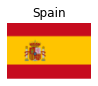

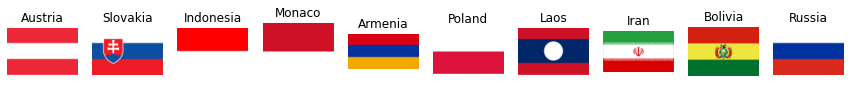

In [7]:
country = ['-'.join([semiword.capitalize() for semiword in input().split()])]
flag_displaying(country)

print("Is simlar to:")

country_list = []
# In this loop we add the 10 nearest flags of the given data
for i,ed in enumerate(set_list):
    if ed[0] == country[0]:
        country_list.append(ed[1])
# And then we show these 10 flags
flag_displaying(country_list)

# GRAPHS

## First graph: Directed and weighted graph with all the edges

#### Building the graph

In [8]:
G1 = nx.DiGraph()

for i in (list(df.index)):
    G1.add_node(i)
    
edges = set_list
G1.add_weighted_edges_from(edges)

#### Analyzing the graph

Most important nodes given the 3 centrality methods.
        Degree        Closeness     Betweeness
0      Bahrain          Austria      Gibraltar
1  Switzerland            Ghana  Guinea-Bissau
2       Turkey          Burkina     Mozambique
3      Denmark          Bahrain        Austria
4        Nauru          Hungary       Sao-Tome
5      Hungary          Bolivia           Iran
6        Ghana  Maldive-Islands         Gambia
7      Armenia          Denmark           Togo
8      Tunisia      Switzerland    Philippines
9     Cambodia            Libya        Ukraine 

We can see that Austria and Bahrian are the countries with the highest score in the centralities of their flags.


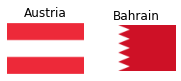

In [9]:
#CENTRALITIES

centralities(G1)

print("We can see that Austria and Bahrian are the countries with the highest score in the centralities of their flags.")

flag_displaying(["Austria", "Bahrain"])

## Second graph: Austria graph

This will be a graph of Austria and his neighbours with all the possible connections between the nodes.

#### Creation of the edges and nodes

In [10]:
austria_edges = []
austria_nodes = []

for edge in edges:
    if "Austria" in edge:
        austria_nodes.append(edge[0])
        austria_nodes.append(edge[1])
        
austria_nodes = set(austria_nodes)

for edge in edges:
    # We only insert edges that connect the austria_nodes between them
    if (edge[0] in austria_nodes) and (edge[1] in austria_nodes):
        austria_edges.append(edge)

print("The graph will have", len(austria_nodes)-1, "nodes + Austria.")
print("There will be" , len(austria_edges) , "edges. ")

The graph will have 18 nodes + Austria.
There will be 136 edges. 


#### Building the graph

In [11]:
G2 = nx.DiGraph()

for i in austria_nodes:
    G2.add_node(i)
    
G2.add_weighted_edges_from(austria_edges)

#### Plotting the graph

c:\users\agarriga2\appdata\local\programs\python\python38\lib\site-packages\networkx\drawing\layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


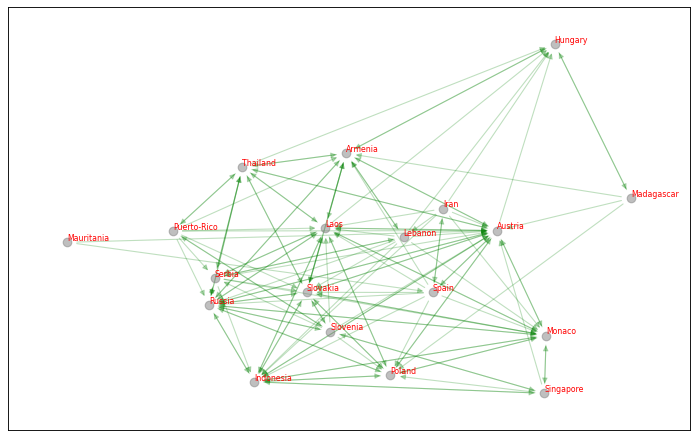

In [12]:
graph_plotting(G2, 60, 7, (11, 7), 2)

#### Analyzing the graph

Most important nodes given the 3 centrality methods.
      Degree  Closeness Betweeness
0    Austria    Austria    Austria
1       Laos       Laos    Armenia
2     Russia     Russia      Spain
3   Slovakia   Slovakia       Laos
4  Indonesia  Indonesia     Russia
5     Monaco     Poland    Hungary
6    Armenia     Monaco   Thailand
7     Poland    Armenia   Slovakia
8   Thailand    Hungary   Slovenia
9     Serbia   Thailand  Indonesia 

A part from Austria, the countries with a higher centrality in this graph are Laos, Russia and Slovakia.


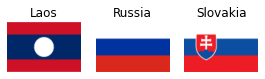

In [13]:
#CENTRALITIES

centralities(G2)

print("A part from Austria, the countries with a higher centrality in this graph are Laos, Russia and Slovakia.")

flag_displaying(["Laos", "Russia", "Slovakia"])

## Third graph: Undirected shorter graph with the best edges

This undirected graph consists of displaying only the 65 edges with the lower distance and his nodes.

In [14]:
# We sort the edges from least to most weight
edges.sort(key=lambda x: x[2])
# We collect the 130 best edges
edges130 = edges[:130]

nodes130 = []
for edge in edges130:
    nodes130.append(edge[0])
    nodes130.append(edge[1])
        
nodes130 = set(nodes130)

#### Building the graph

We use an undirected graph, so the 130 edges will become 65 because there are 2 pairs of each.

In [15]:
G3 = nx.Graph()

for i in nodes130:
    G3.add_node(i)
    
G3.add_weighted_edges_from(edges130)

#### Plotting the graph

c:\users\agarriga2\appdata\local\programs\python\python38\lib\site-packages\networkx\drawing\layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


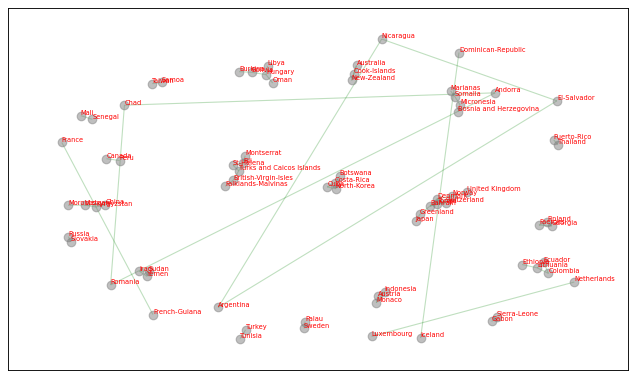

In [16]:
graph_plotting(G3, 60, 6, (10, 6), 2)

#### Analyzing the pragh

INFO
The graph has 75 nodes and 2140 edges.

DENSITY
Density of the graph: 0.023423423423423424
Density of Bahrain graph: 0.39766081871345027
The Bahrain graph is 16.97705802968961 times more dense thant the actual.
The low density of this graph makes us think that there are a lot of connected components.

CONNECTED COMPONENTS
Connected_component0
Countries of the CC: {'Bahrain', 'Greenland', 'Switzerland', 'Norway', 'Tonga', 'United Kingdom', 'Japan', 'Denmark'}
Nodes of the CC: 8 - Edges of the CC: 11
Density of the CC: 0.39285714285714285 

Connected_component1
Countries of the CC: {'Turks and Caicos Islands', 'St-Helena', 'Montserrat', 'Fiji', 'British-Virgin-Isles', 'Falklands-Malvinas'}
Nodes of the CC: 6 - Edges of the CC: 6
Density of the CC: 0.4 

Connected_component2
Countries of the CC: {'Burkina', 'Hungary', 'Oman', 'Bolivia', 'Libya'}
Nodes of the CC: 5 - Edges of the CC: 4
Density of the CC: 0.4 

Connected_component3
Countries of the CC: {'Micronesia', 'Bosnia and Herzeg

C:\Users\agarriga2\AppData\Local\Temp\ipykernel_11064\1354034072.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(figsize=(len(country_list)*1.5,len(country_list)*1.5))


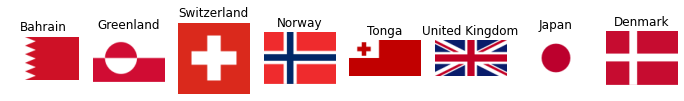

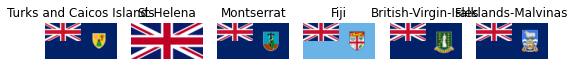

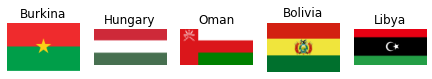

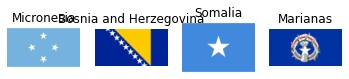

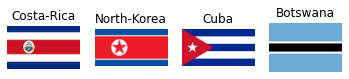

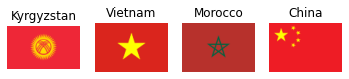

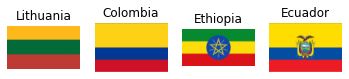

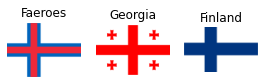

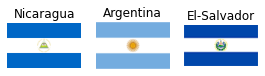

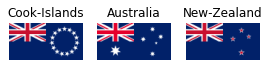

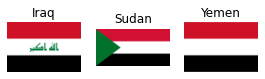

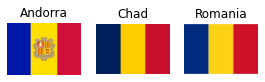

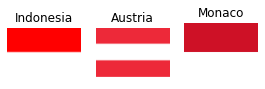

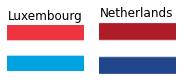

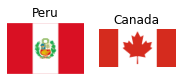

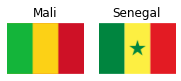

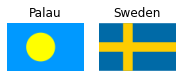

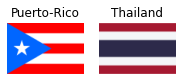

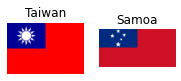

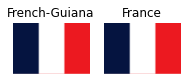

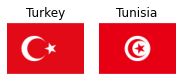

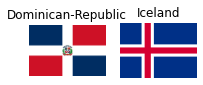

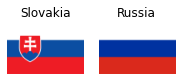

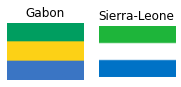

In [17]:
print("INFO")
print("The graph has", len(G3.nodes), "nodes and", len(edges), "edges.\n")

print("DENSITY")
print("Density of the graph:" , nx.density(G3))
print("Density of Bahrain graph:" , nx.density(G2))
print("The Bahrain graph is" , nx.density(G2)/nx.density(G3), "times more dense thant the actual.")
print("The low density of this graph makes us think that there are a lot of connected components.\n")

print("CONNECTED COMPONENTS")
connected_components(G3)

## Fourth graph: Path graph

Firstly, we will create the graph with all the nodes but no edges. Then we will add the edges (we will start with the ones with the lower distance) until all the nodes are connected in a single component.

#### Building the graph

In [18]:
# Creating the graph (first withouth edges): 

G4 = nx.Graph()

for i in (list(df.index)):
    G4.add_node(i)
    

# We are adding the edges one by one until the graph is all connected
# As a condition, the edges that create another path will not be added
# Also, it is directed graph, so for example, we will not add A->B if B->A is already in the graph

ccs = len(list(df.index))
for edge in edges:
    if ccs == 1:
        break
    if G4.has_edge(edge[0], edge[1]) == False:
        G4.add_weighted_edges_from([edge])
        # if a new edge doesn't join 2 components, thi edge will be removed
        if (nx.number_connected_components(G4) != ccs-1):
            G4.remove_edge(edge[0], edge[1])
        ccs = nx.number_connected_components(G4)

#### Plotting the graph

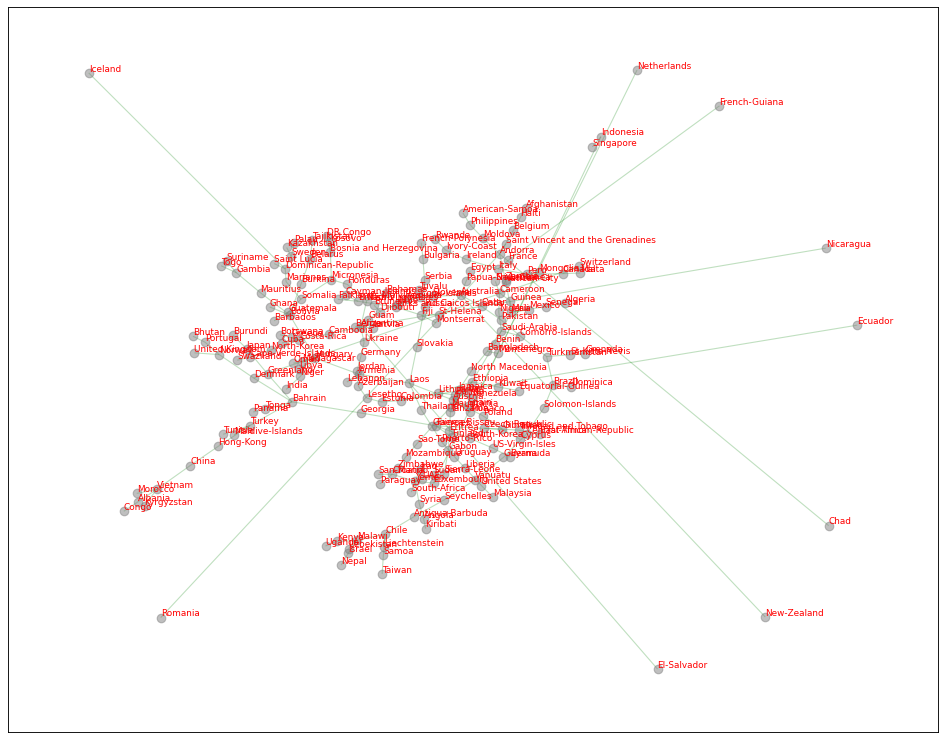

In [19]:
graph_plotting(G4, 60, 8, (15, 12), 2)

#### Analyzing the graph

Most important nodes given the 3 centrality methods.
       Degree   Closeness       Betweeness
0       Yemen    Ethiopia         Ethiopia
1     Andorra       Benin          Austria
2     Hungary        Iran             Mali
3   Argentina        Mali            Benin
4    Ethiopia     Austria             Iran
5  Costa-Rica   Lithuania     Saudi-Arabia
6     Austria      Guinea         Cameroon
7        Mali  Mauritania           Guinea
8     Bahrain      Kuwait          Nigeria
9        Laos      Poland  Comorro-Islands 

The countries with the highest centralities are Ethiopia, Benin and Mali.


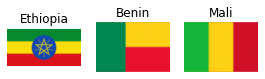

In [20]:
#CENTRALITIES

centralities(G4)

print("The countries with the highest centralities are Ethiopia, Benin and Mali.")

flag_displaying(["Ethiopia", "Benin", "Mali"])

#### Longest distance between 2 nodes

In [21]:
longest_path = [[],0]

# We iterate all possible node combinations
for i1,n1 in enumerate(G4.nodes):
    for i2,n2 in enumerate(G4.nodes):
        if i2 > i1:  # We avoid repeating a node combination
            for path in sorted(nx.all_simple_edge_paths(G4, n1, n2)):
                values = [sum(G4.get_edge_data(*edge).values()) for edge in path]  # weights of the edges
                weight_sum = sum(values)  # sum of the weights of the edges
                if weight_sum > longest_path[1]:
                    longest_path[0] = path
                    longest_path[1] = weight_sum
                    
print("The longest path in the graph 4 is the one that connects", longest_path[0][0][0], "with", longest_path[0][-1][1], "\n")
print("It has an accumulative weight of", longest_path[1], "\n")
nodes_path = []
for edge in longest_path[0][:-1]:
    nodes_path.append(edge[0])
nodes_path.append(longest_path[0][-1][1])
print("It goes through", len(nodes_path) , "nodes. The nodes are these", nodes_path)

The longest path in the graph 4 is the one that connects Kazakhstan with Uganda 

It has an accumulative weight of 91.49319931382695 

It goes through 36 nodes. The nodes are these ['Kazakhstan', 'Sweden', 'Dominican-Republic', 'Marianas', 'Somalia', 'Micronesia', 'Honduras', 'Nauru', 'Argentina', 'Ukraine', 'Germany', 'Jordan', 'Azerbaijan', 'Lesotho', 'Estonia', 'Colombia', 'Lithuania', 'Ethiopia', 'Benin', 'Mali', 'Guinea', 'Cameroon', 'Nigeria', 'Saudi-Arabia', 'Comorro-Islands', 'Turkmenistan', 'Brazil', 'Solomon-Islands', 'Central-African-Republic', 'Guyana', 'Vanuatu', 'Seychelles', 'Antigua-Barbuda', 'Chile', 'Malawi', 'Uganda']


## Fifth graph: European graph

This one consists of a graph where we only have the European countries. This time, we will make 4 edges for node.

In [22]:
# List of the European countries
europe = df[df['landmass'] == 3].index

X2 = X.copy()

X2['is_europe'] = [i in europe for i in X.index.values]
X2 = X2[X2['is_europe'] == True]
X2 = X2.drop(["is_europe"], axis=1)

# DF with the European countries
X2.head()

,bars,stripes,colours,red,green,blue,gold,white,black,orange,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
country,,,,,,,,,,,,,,,,,,,,,
Albania,0,0,3,1,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,6,6
Andorra,3,0,3,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,6
Armenia,0,3,3,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,6,5
Austria,0,3,2,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,6,6
Azerbaijan,0,3,4,1,1,1,0,1,0,0,...,0,0,1,1,0,0,0,0,1,4


In [23]:
knn = KNeighborsClassifier(3)
null = [1]*len(X2)
knn.fit(X2, null)
probs, couples = knn.kneighbors(X2,5)

set_list = []
for i, (x,y) in enumerate(zip(probs, couples)):
    if i != y[0]:  # in some cases, the position has to be swapped
        pos = list(y).index(i)
        y[0], y[pos] = y[pos], y[0]
    base = X2.iloc[y[0]].name
    for pos in range(1,5):
        set_list.append([base, X2.iloc[y[pos]].name, x[pos]])

In [24]:
G5 = nx.DiGraph()

for i in (europe):
    G5.add_node(i)
    
euroedges = set_list
G5.add_weighted_edges_from(euroedges)

#### Plotting the graph

c:\users\agarriga2\appdata\local\programs\python\python38\lib\site-packages\networkx\drawing\layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


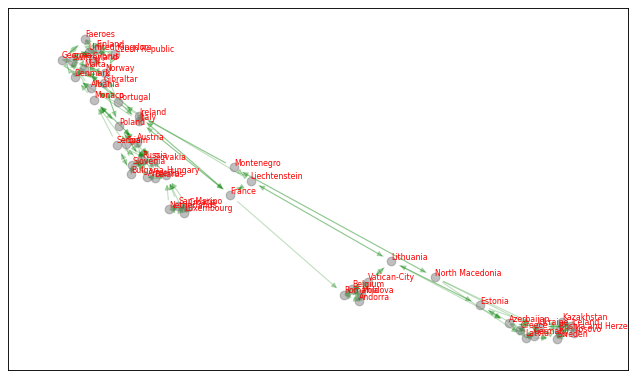

In [25]:
graph_plotting(G5, 60, 7, (10,6), 2)

#### Analyzing the graph

Most important nodes given the 3 centrality methods.
        Degree       Closeness     Betweeness
0      Ukraine     Switzerland      Lithuania
1  Switzerland          Norway  Liechtenstein
2      Austria         Denmark       Portugal
3     Slovakia         Georgia      Gibraltar
4      Denmark  United Kingdom        Estonia
5       Norway  Czech Republic     Azerbaijan
6       Russia         Faeroes         Poland
7       Sweden       Gibraltar        Ukraine
8       Poland         Finland   Vatican-City
9      Hungary          Poland         France 

The country with the highest centralities is Switzerland.


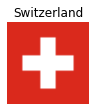

In [26]:
#CENTRALITIES

centralities(G5)

print("The country with the highest centralities is Switzerland.")

flag_displaying(["Switzerland"])

#### Clustering (deleting nodes)

The node to delete is: Montenegro
The node to delete is: Lithuania
The node to delete is: Monaco
The node to delete is: Gibraltar
The node to delete is: France
The node to delete is: Hungary


c:\users\agarriga2\appdata\local\programs\python\python38\lib\site-packages\networkx\drawing\layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


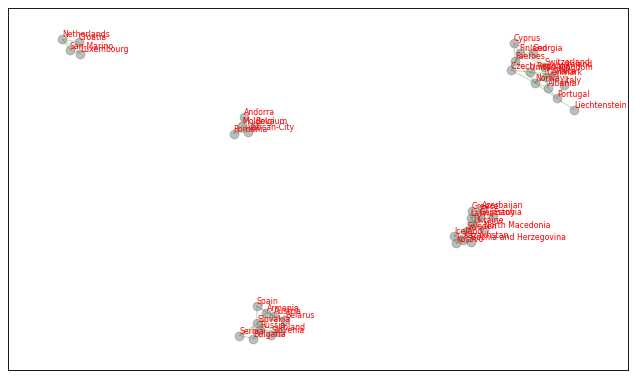

After deleting 6 nodes. We have the 4 connected components.
Connected_component0
Countries of the CC: {'Malta', 'Portugal', 'Georgia', 'Czech Republic', 'Finland', 'Albania', 'Switzerland', 'Norway', 'Ireland', 'Italy', 'Faeroes', 'Cyprus', 'United Kingdom', 'Liechtenstein', 'Denmark'}
Nodes of the CC: 15 - Edges of the CC: 37
Density of the CC: 0.3523809523809524 

Connected_component1
Countries of the CC: {'Germany', 'Greece', 'North Macedonia', 'Azerbaijan', 'Kazakhstan', 'Estonia', 'Kosovo', 'Sweden', 'Ukraine', 'Bosnia and Herzegovina', 'Iceland', 'Latvia'}
Nodes of the CC: 12 - Edges of the CC: 32
Density of the CC: 0.48484848484848486 

Connected_component2
Countries of the CC: {'Belarus', 'Armenia', 'Russia', 'Bulgaria', 'Spain', 'Poland', 'Slovakia', 'Slovenia', 'Serbia', 'Austria'}
Nodes of the CC: 10 - Edges of the CC: 24
Density of the CC: 0.5333333333333333 

Connected_component3
Countries of the CC: {'Andorra', 'Belgium', 'Moldova', 'Romania', 'Vatican-City'}
Nodes of the

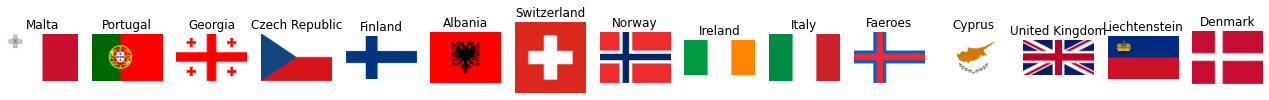

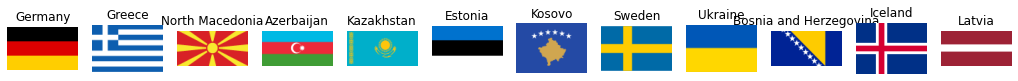

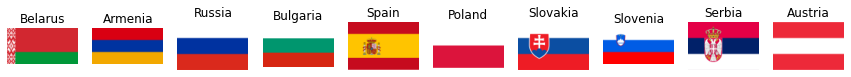

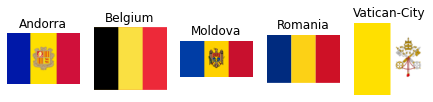

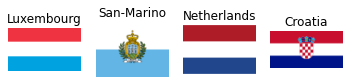

In [27]:
n_ccs = 1
nodes_deleted = 0

# We convert it to undirected
G5_= G5.to_undirected()

while n_ccs < 5:
    # We get the score of the highest betweenness centrality for each node 
    clust = nx.betweenness_centrality(G5_).items()
    # We select and later delete, the one that has the higher score
    node_to_delete = sorted(clust, reverse=False, key=lambda pair: -pair[1])[0][0]
    
    print("The node to delete is:", node_to_delete)
    G5_.remove_node(node_to_delete)
    
    
    # We count the number of connectes components
    n_ccs = nx.number_connected_components(G5_)
    nodes_deleted += 1

graph_plotting(G5_, 60, 7, (10,6), 2)
print("After deleting", nodes_deleted, "nodes. We have the 4 connected components.")

connected_components(G5_)

## Sixth graph: TOP population graph

In this last part, I'll make a graph with only the TOP25 countries in the world in terms of population.

In [28]:
# List of the TOP25 countries
top25 = df.sort_values(by='population', ascending=False)[:25].index

X3 = X.copy()
X3['is_top25'] = [i in top25 for i in X3.index.values]
X3 = X3[X3['is_top25'] == True]
X3 = X3.drop(["is_top25"], axis=1)

# DF with the European countries
X3.head()

,bars,stripes,colours,red,green,blue,gold,white,black,orange,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
country,,,,,,,,,,,,,,,,,,,,,
Bangladesh,0,0,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,4
Brazil,0,0,4,0,1,1,1,1,0,0,...,0,0,2,0,0,0,0,1,4,4
China,0,0,2,1,0,0,1,0,0,0,...,0,0,2,0,0,0,0,0,6,6
DR Congo,0,0,3,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
Egypt,0,3,4,1,0,0,1,1,1,0,...,0,0,0,0,0,0,1,1,6,0


In [29]:
knn = KNeighborsClassifier(3)
null = [1]*len(X3)
knn.fit(X3, null)
probs, couples = knn.kneighbors(X3,4)

set_list = []
for i, (x,y) in enumerate(zip(probs, couples)):
    if i != y[0]:  # in some cases, the position has to be swapped
        pos = list(y).index(i)
        y[0], y[pos] = y[pos], y[0]
    base = X3.iloc[y[0]].name
    for pos in range(1,4):
        set_list.append([base, X3.iloc[y[pos]].name, x[pos]])

In [30]:
G6 = nx.DiGraph()

for i in (top25):
    G6.add_node(i)
    
top25edges = set_list
G6.add_weighted_edges_from(top25edges)

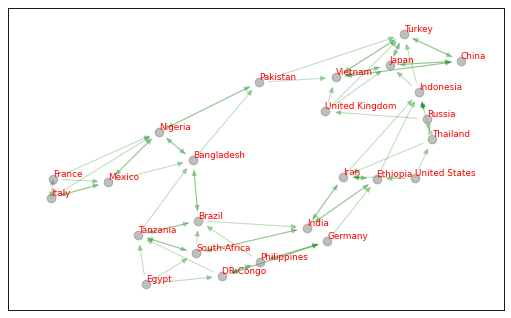

In [31]:
graph_plotting(G6, 60, 8, (8,5), 2)

#### Analyzing the graph

Most important nodes given the 3 centrality methods.
       Degree   Closeness    Betweeness
0      Turkey      Turkey    Bangladesh
1     Vietnam     Vietnam         India
2     Nigeria       Japan        Brazil
3       Japan       India       Nigeria
4    Tanzania       China     Indonesia
5   Indonesia      Brazil  South-Africa
6        Iran        Iran          Iran
7      Brazil    Ethiopia      Ethiopia
8  Bangladesh    Tanzania      Tanzania
9    Ethiopia  Bangladesh        Russia 

The countries with the highest centralities are Turkey, Vietnam, India, Nigeria & Japan.


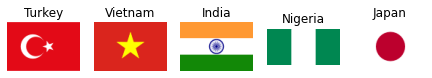

In [32]:
#CENTRALITIES

centralities(G6)

print("The countries with the highest centralities are Turkey, Vietnam, India, Nigeria & Japan.")

flag_displaying(["Turkey", "Vietnam", "India", "Nigeria", "Japan"])

#### Clustering (deleting edges)

The edge to delete is: ('Pakistan', 'Turkey')
The edge to delete is: ('Pakistan', 'Vietnam')
The edge to delete is: ('India', 'Brazil')
The edge to delete is: ('India', 'South-Africa')
The edge to delete is: ('Ethiopia', 'Germany')
The edge to delete is: ('Bangladesh', 'Tanzania')
The edge to delete is: ('Brazil', 'Bangladesh')
The edge to delete is: ('Indonesia', 'Turkey')
The edge to delete is: ('Indonesia', 'Japan')
The edge to delete is: ('Russia', 'United Kingdom')


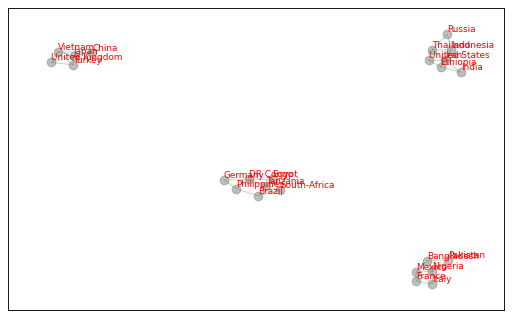

After deleting 10 edges. We have the 4 connected components.
Connected_component0
Countries of the CC: {'United States', 'Russia', 'Iran', 'Indonesia', 'India', 'Ethiopia', 'Thailand'}
Nodes of the CC: 7 - Edges of the CC: 12
Density of the CC: 0.5714285714285714 

Connected_component1
Countries of the CC: {'Germany', 'South-Africa', 'Egypt', 'Brazil', 'Tanzania', 'DR Congo', 'Philippines'}
Nodes of the CC: 7 - Edges of the CC: 11
Density of the CC: 0.5238095238095238 

Connected_component2
Countries of the CC: {'France', 'Nigeria', 'Mexico', 'Italy', 'Pakistan', 'Bangladesh'}
Nodes of the CC: 6 - Edges of the CC: 10
Density of the CC: 0.6666666666666666 

Connected_component3
Countries of the CC: {'China', 'Vietnam', 'Turkey', 'United Kingdom', 'Japan'}
Nodes of the CC: 5 - Edges of the CC: 9
Density of the CC: 0.9 

There's an amount of 4 connected components.


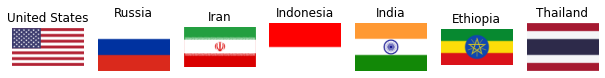

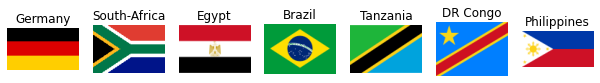

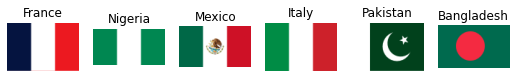

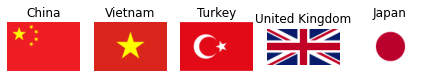

In [33]:
n_ccs = 1
edges_deleted = 0

# We convert it to undirected
G6_= G6.to_undirected()

while n_ccs != 4:
    # We get the score of the highest betweenness centrality for each edge 
    edge_betwenness = nx.edge_betweenness_centrality(G6_).items()
    # We selecet, an later, delete,, the one that has the highest score
    edge_to_delete = sorted(edge_betwenness, key=lambda pair: -pair[1])[0][0]
    
    print("The edge to delete is:", edge_to_delete)
    G6_.remove_edge(*edge_to_delete)
    
    # We count the number of connected components
    n_ccs = nx.number_connected_components(G6_)
    edges_deleted += 1
    
graph_plotting(G6_, 60, 8, (8,5), 2)

print("After deleting", edges_deleted, "edges. We have the 4 connected components.")

connected_components(G6_)